In [3]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import os

2024-05-08 15:35:28.809719: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
def init_ela(tl, tr, bl, br):
    x = np.linspace(0, 1, 451)
    y = np.linspace(0, 1, 301)
    X, Y = np.meshgrid(x, y)
    Z = bl * (1 - X) * (1 - Y) + br * X * (1 - Y) + tl * (1 - X) * Y + tr * X * Y
    return Z

In [5]:
fn = 'Data/alps_topo/observation.nc'
ds = nc.Dataset(fn)
obs=ds['max_thk_obs']
obs_gfp=np.array(obs)
topg=ds['topg']
topg=np.array(topg)
X=ds['x'][:]
Y=ds['y'][:]


## Scale down the observations 
to match Bini map

In [4]:
# Find the maximum value in the array
max_thickness = np.max(obs[:])
# Calculate the scale factor such that the maximum thickness is reduced by 400
scale_factor = (max_thickness - 400) / max_thickness

# Scale the glacier thickness array
scaled_glacier_thickness = obs[:] * scale_factor

# Get the index of the maximum value
index = np.unravel_index(np.argmax(obs[:], axis=None), obs[:].shape)
print(f"The index of the highest value is: {index}")

The index of the highest value is: (154, 119)


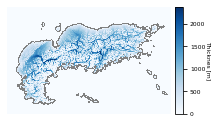

In [7]:
cm_converter=1/2.54
fig = plt.figure(figsize=(8*cm_converter,5*cm_converter))

ax1 = fig.add_subplot(111)
# ax1.set_title('The Observations', fontsize=20)
im1 = ax1.pcolor(X, Y, obs, cmap='Blues', shading='auto')

# Adding filled contours
contours = ax1.contourf(X, Y, obs[:], [5,10], cmap='gray')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, format="%d", cax=cax1)
cbar1.ax.tick_params(labelsize=6)
cbar1.ax.set_ylabel('Thicknes [m]', fontsize=6, rotation=270, labelpad=5)
ax1.axis("off")
plt.savefig('obs.png', bbox_inches='tight', dpi=300)
plt.show()

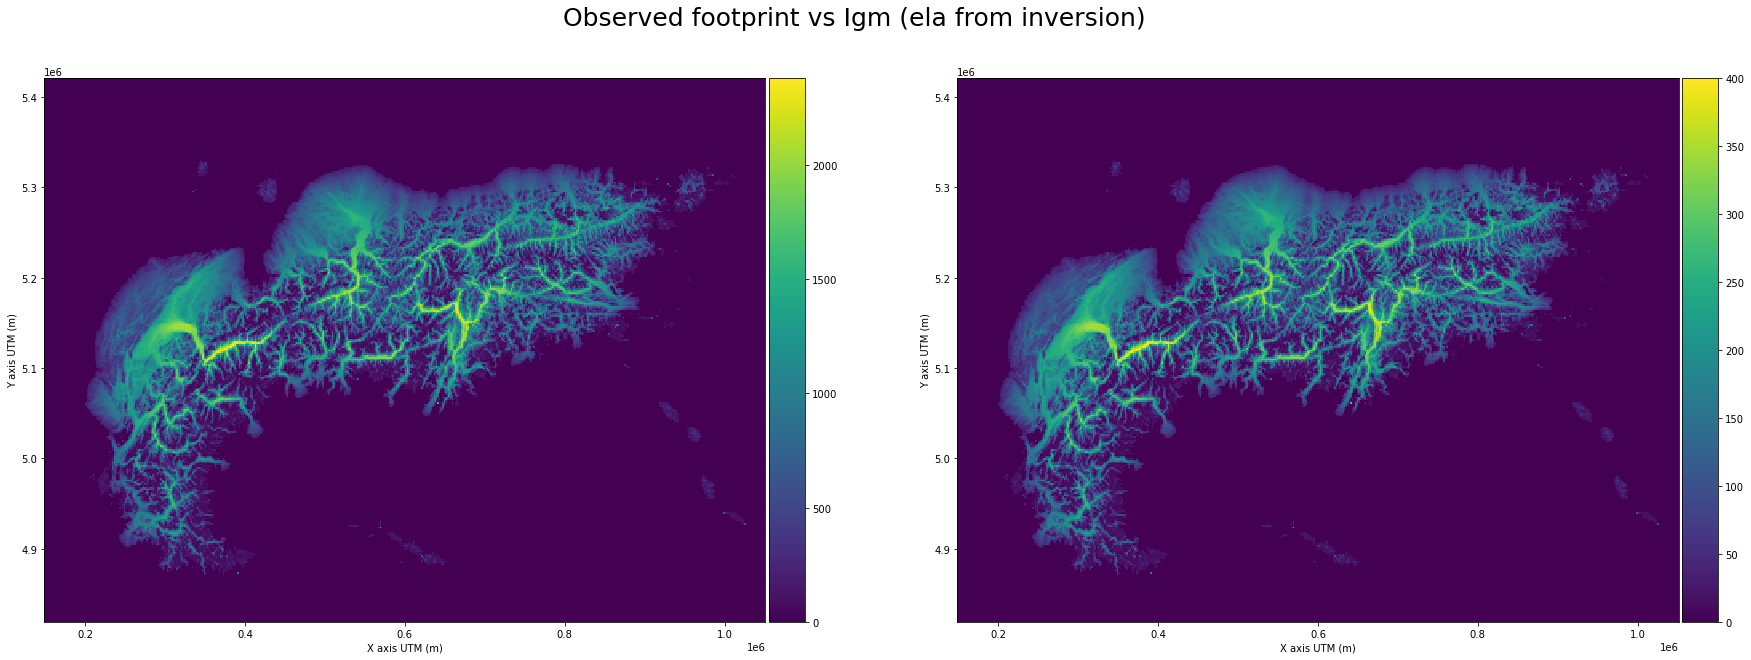

In [8]:
fig = plt.figure(figsize=(30, 10))
fig.suptitle('Observed footprint vs Igm (ela from inversion)',fontsize=25)
ax1 = fig.add_subplot(121)
im1 = ax1.pcolor(X,Y,obs)
ax1.set_xlabel('X axis UTM (m)',fontsize=10)
ax1.set_ylabel('Y axis UTM (m)',fontsize=10)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
im2 = ax2.pcolor(X,Y,obs-scaled_glacier_thickness)
ax2.set_xlabel('X axis UTM (m)',fontsize=10)
ax2.set_ylabel('Y axis UTM (m)',fontsize=10)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

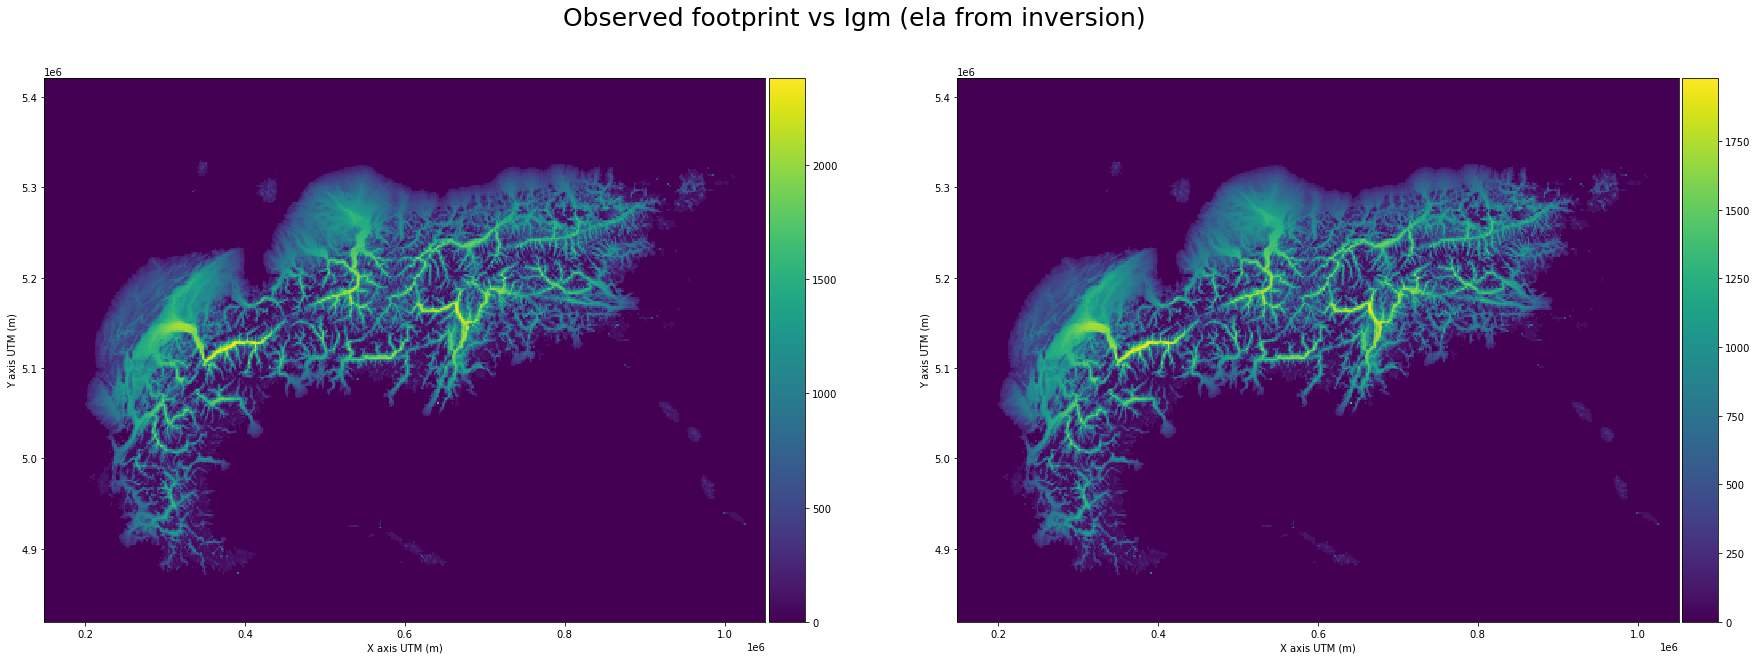

In [ ]:
fig = plt.figure(figsize=(30, 10))
fig.suptitle('Observed footprint vs Igm (ela from inversion)',fontsize=25)
ax1 = fig.add_subplot(121)
im1 = ax1.pcolor(X,Y,obs)
ax1.set_xlabel('X axis UTM (m)',fontsize=10)
ax1.set_ylabel('Y axis UTM (m)',fontsize=10)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
im2 = ax2.pcolor(X,Y,footprint-obs)
ax2.set_xlabel('X axis UTM (m)',fontsize=10)
ax2.set_ylabel('Y axis UTM (m)',fontsize=10)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

## Visualize parameter evolution.

In [8]:
ela=np.load('parameterevolution/Inverted_ELA.npy')
time=np.load('parameterevolution/Inverted_time.npy')
ela=np.load('parameterevolution/ela_step700.npy')
time=np.load('parameterevolution/time_step700.npy')


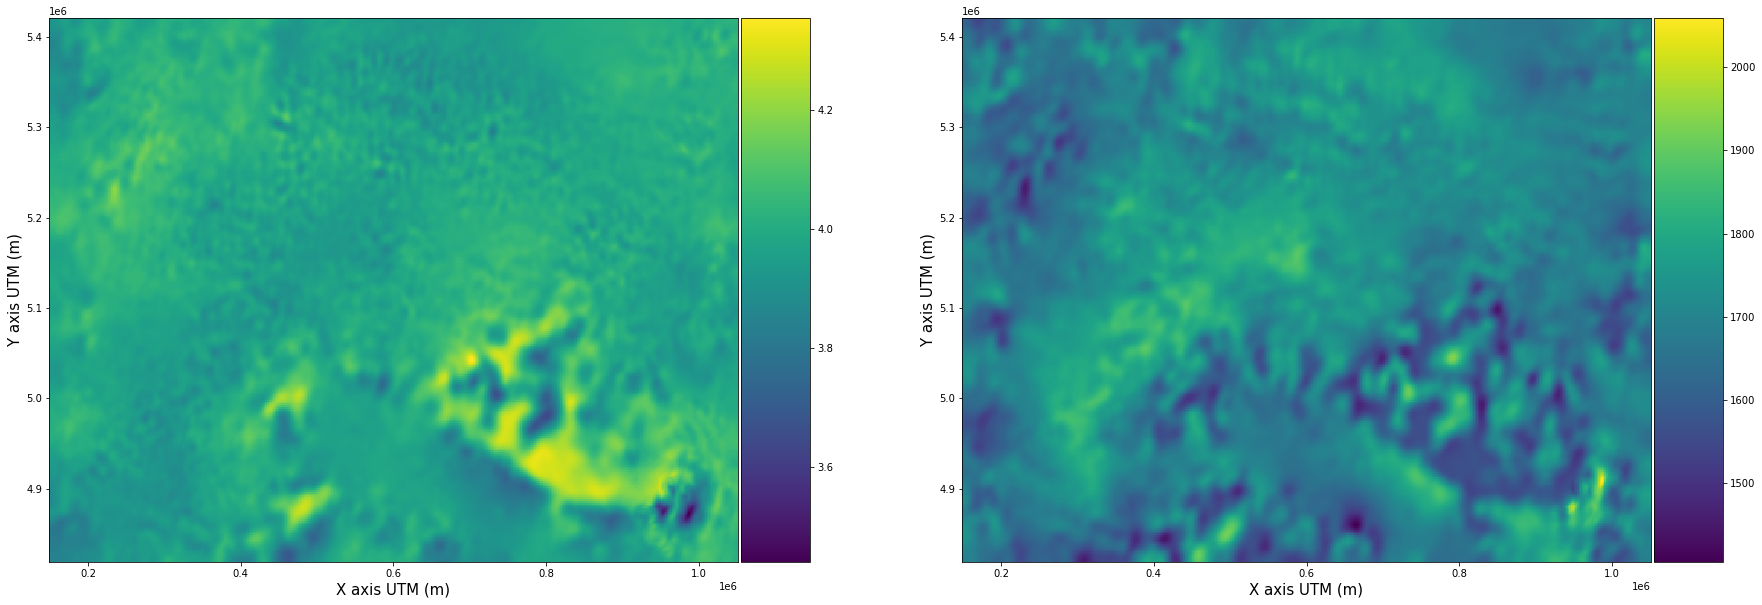

In [9]:
fig = plt.figure(figsize=(30, 10))
#fig.suptitle('Observed footprint vs inversion result',fontsize=25)
ax1 = fig.add_subplot(121)
im1 = ax1.pcolor(X,Y,time)
ax1.set_xlabel('X axis UTM (m)',fontsize=15)
ax1.set_ylabel('Y axis UTM (m)',fontsize=15)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
im2 = ax2.pcolor(X,Y,ela)
ax2.set_xlabel('X axis UTM (m)',fontsize=15)
ax2.set_ylabel('Y axis UTM (m)',fontsize=15)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

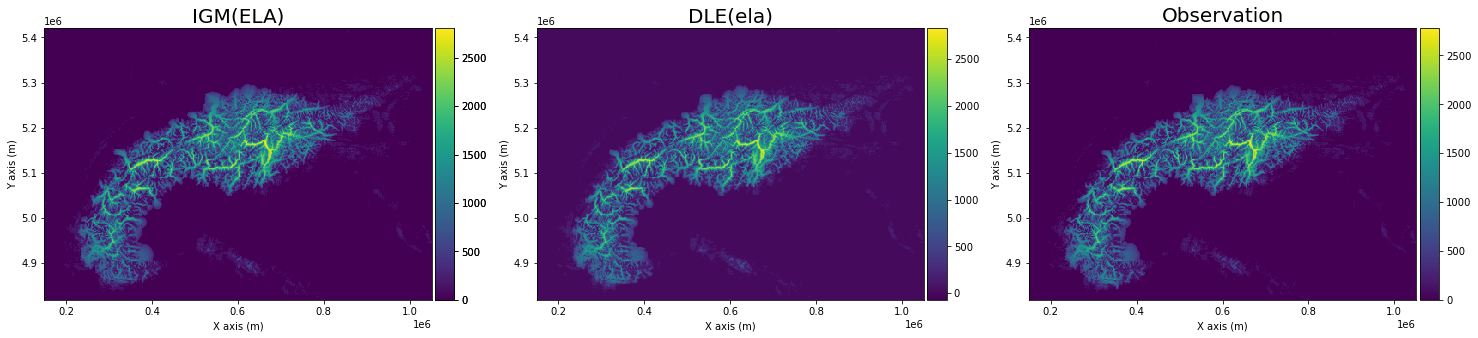

In [13]:
fig = plt.figure(figsize=(25, 5))
#fig.suptitle('ELA  vs Emulator footprint',fontsize=25)

ax1 = fig.add_subplot(131)
im1 = ax1.pcolor(X,Y,footprint)
ax1.set_xlabel('X axis (m)',fontsize=10)
ax1.set_ylabel('Y axis (m)',fontsize=10)
ax1.set_title('IGM(ELA)',fontsize=20)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(132)
im2 = ax2.pcolor(X,Y,Pred)
ax2.set_xlabel('X axis (m)',fontsize=10)
ax2.set_ylabel('Y axis (m)',fontsize=10)
ax2.set_title('DLE(ela)',fontsize=20)


divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax3 = fig.add_subplot(133)
im3 = ax3.pcolor(X,Y,obs)
ax3.set_xlabel('X axis (m)',fontsize=10)
ax3.set_ylabel('Y axis (m)',fontsize=10)
ax3.set_title('Observation',fontsize=20)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

## visualize cost and regularization

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Observed footprint - Emulator footprint = {0:.2f} m'.format(np.mean(obs-Pred)), fontweight ="bold")
plt.imshow(obs-Pred,cmap ='viridis')
plt.colorbar()
plt.gca().invert_yaxis()

plt.show()

### Normalized metrics

In [ ]:
path1='/home/klleshi/Desktop/DLE2/fordle/ela_data/test/ALP06_A78_C0/ex.nc'
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
dts = nc.Dataset(path1)
#load ela and the corresponding FP.
ela_test=dts['ela']
ela_test=tf.cast(ela_test,tf.float32)
FP_test=dts['max_thk']
FP_test=tf.cast(FP_test,tf.float32)

In [ ]:
mae_list=np.zeros(46)
mse_list=np.zeros(46)
for i in range (46):
    Pred_i=predict(ela_test[i])
    obs_i=FP_test[i]
    mae_list[i]= mae(obs_i, Pred_i).numpy()/np.sum(obs_i)
    mse_list[i]= mse(obs_i, Pred_i).numpy()/np.sum(obs_i)
    
    

In [ ]:
print(np.mean(mae_list),np.mean(mse_list))

In [ ]:
mea=tf.reduce_mean(footprint-obs)

## Compare two netcdf files

In [5]:

# Load the first NetCDF file
file1 = nc.Dataset('ex.nc')
# Load the second NetCDF file
file2 = nc.Dataset('obs_test.nc')

# Get the variables from both files
variables1 = file1.variables.keys()
variables2 = file2.variables.keys()

# Check if the variables are the same in both files
if variables1 == variables2:
    print("The variables in both files are the same.")
else:
    print("The variables in both files are different.")



The variables in both files are different.


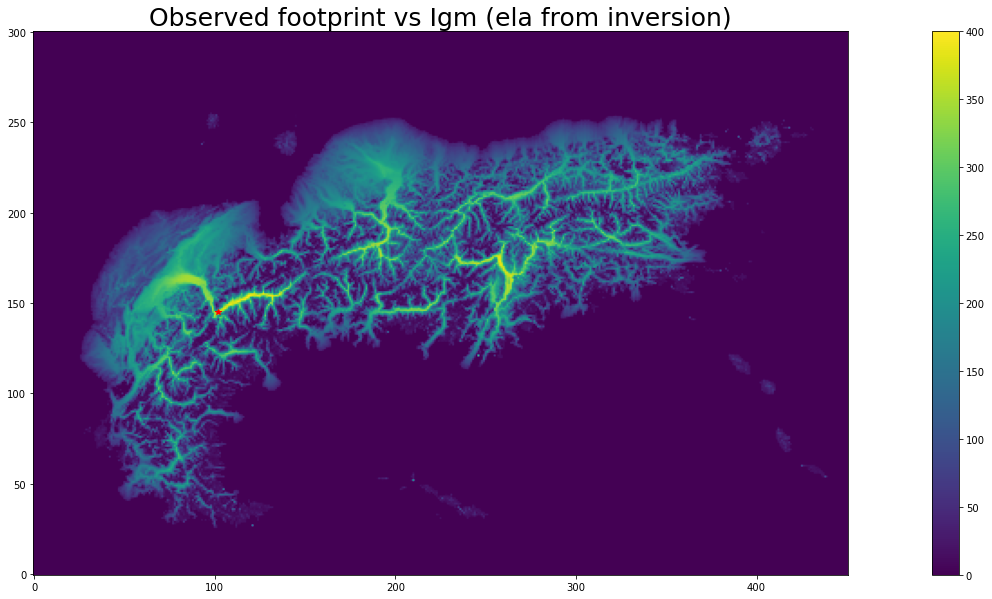

In [38]:
plt.figure(figsize=(30, 10))
plt.title('Observed footprint vs Igm (ela from inversion)',fontsize=25)
plt.imshow(obs[:]-scaled_glacier_thickness)
plt.colorbar()
plt.plot(102, 145, marker='*', color='red')

plt.gca().invert_yaxis()


In [9]:
np.mean(obs[:]-scaled_glacier_thickness)

32.226616

## Make observations file

In [15]:
def create_nc_file(time, a, beta, c):
    time_value = np.zeros(topg.shape) + time
    A_value = np.zeros(topg.shape) + a
    beta_value = np.zeros(topg.shape) + beta
    c_value = np.zeros(topg.shape) + c

    ela = init_ela(1300,1700,1700,2000)

    # Create new NetCDF file
    fn_out = f'obs_t{time}_A{a}b{beta}c{c}.nc'
    ds_out = nc.Dataset(fn_out, 'w')

    # Create dimensions
    ny, nx = topg.shape
    ds_out.createDimension('x', nx)
    ds_out.createDimension('y', ny)

    # Create variables
    topg_var = ds_out.createVariable('topg', 'f8', ('y', 'x'))
    max_thk_obs_var = ds_out.createVariable('max_thk_obs', 'f8', ('y', 'x'))
    ela_var = ds_out.createVariable('ela', 'f8', ('y', 'x'))
    time_var = ds_out.createVariable('time', 'f8', ('y', 'x'))
    A = ds_out.createVariable('A', 'f8', ('y', 'x'))
    beta = ds_out.createVariable('beta', 'f8', ('y', 'x'))
    c = ds_out.createVariable('c', 'f8', ('y', 'x'))
    X_var = ds_out.createVariable('x', 'f8', ('x'))  
    Y_var = ds_out.createVariable('y', 'f8', ('y')) 

    # Write data to variables
    topg_var[:] = topg
    max_thk_obs_var[:] = obs[:]
    ela_var[:] = ela  # Set ela to 0, change this value as needed
    time_var[:] = time_value
    A[:] = A_value
    beta[:] = beta_value  # Set ela to 0, change this value as needed
    c[:] = c_value
    X_var[:]=X
    Y_var[:]=Y
    # Close the NetCDF file
    ds_out.close()


In [20]:
for t in [3,4,5]:
    
    create_nc_file(t,78,0.016,2.1)